# Neural Network-Based NLP Sentiment Classification of User Reviews Using BiLSTM and Activation Function Tuning  
**Author: May Cooper**

## Overview

This project applies natural language processing techniques and neural networks to classify the sentiment of user-generated review text. A Bidirectional LSTM (BiLSTM) architecture is implemented using TensorFlow/Keras, enhanced with pre-trained GloVe word embeddings for semantic representation. The model is trained and evaluated across different activation functions (ReLU, sigmoid, tanh) to determine their impact on classification performance. Regularization techniques, including dropout and L2 penalties, are used to improve generalization.

**Research question:**  
What is the effect of different activation functions (e.g., ReLU, sigmoid, tanh) on the performance of the sentiment classification model?

## Goal

Build and evaluate an NLP sentiment classification model by:
1. Preprocessing and tokenizing text data from the UCI Sentiment Labeled Sentences Dataset.
2. Integrating pre-trained GloVe embeddings for semantic vectorization.
3. Designing a BiLSTM-based architecture with tunable activation functions.
4. Training the model with early stopping and dropout to prevent overfitting.
5. Comparing activation function performance using validation accuracy and loss metrics.
6. Visualizing results through training curves and evaluation plots.

#### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the dataset
data = pd.read_csv('sentiment_labelled_sentences/imdb_labelled.txt', sep='\t', header=None)
data.columns = ['sentence', 'label']

# Checking for presence of unusual characters such as emojis, non-English characters
data['unusual_chars'] = data['sentence'].apply(
    lambda x: any(char not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ' for char in x)
)
unusual_char_cnt = data['unusual_chars'].sum()
print(f"Unusual characters found in {unusual_char_cnt} sentences.")

# Vocabulary size
# Tokenizing sentences to calculate vocab size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['sentence'])
vocab_size = len(tokenizer.word_index) + 1  # plus 1 to include padding token
print(f"Vocabulary size in dataset: {vocab_size}")

# Word embedding length
# predefined embedding dimension (100 for GloVe embeddings)
embedding_dim = 100
print(f"Word embedding length: {embedding_dim}")

# Statistical justification for the chosen maximum sequence length
# length of each sentence (in words)
sentence_lengths = data['sentence'].apply(lambda x: len(x.split()))
max_seq_length = int(np.percentile(sentence_lengths, 95))  # 95th percentile
print(f"Max sequence length is {max_seq_length} (95th percentile).")

Unusual characters found in 748 sentences.
Vocabulary size in dataset: 3134
Word embedding length: 100
Max sequence length is 34 (95th percentile).


In [3]:
# Load GloVe embeddings into a dictionary
# embedding matrix
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Visualizations

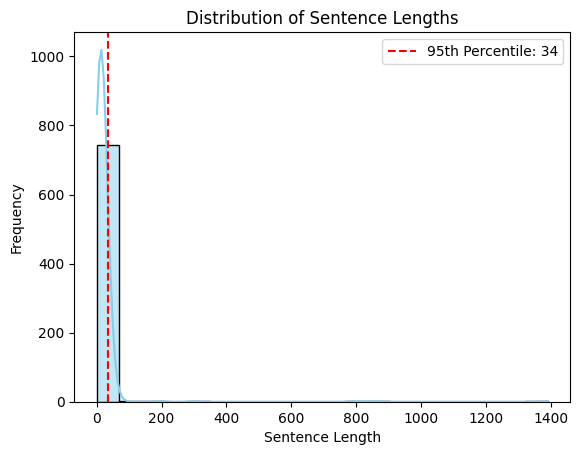

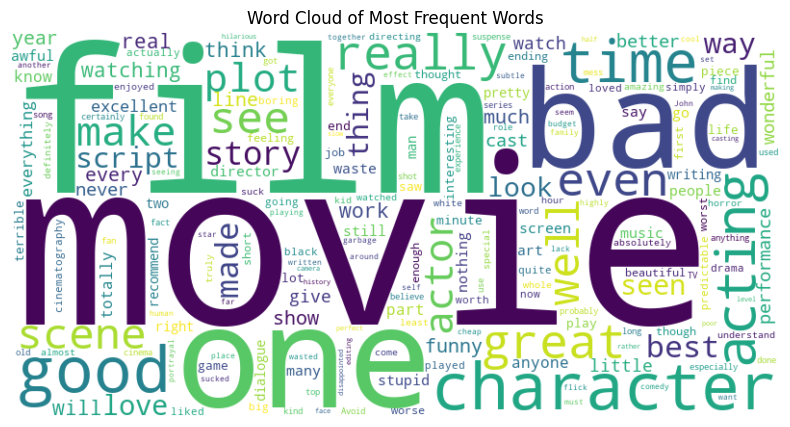

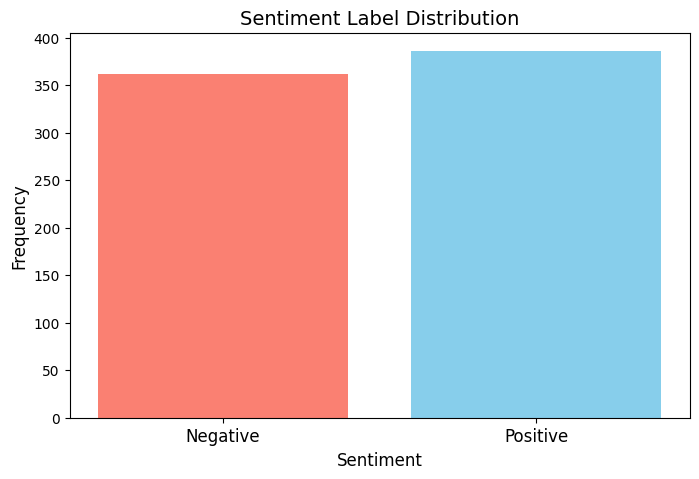

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualize the distribution of sentence lengths
sns.histplot(sentence_lengths, kde=True, bins=20, color='skyblue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.axvline(max_seq_length, color='red', linestyle='--', label=f'95th Percentile: {max_seq_length}')
plt.legend()
plt.show()

# Combine all sentences into a single string
text_data = " ".join(data['sentence'])

# Create word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis'
).generate(text_data)

# word cloud plotting
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

# Count the frequency of each label
label_counts = data['label'].value_counts()

# bar plot of label distribution
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Negative', 'Positive'], fontsize=12)
plt.title('Sentiment Label Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [ ]:
# Padding process explanation and saving the full padded dataset
# Tokenizing and padding sequences
sequences = tokenizer.texts_to_sequences(data['sentence'])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# details of the padding process
print("Padding process:")
print(f"- Padding occurs after the sequence (post-padding).")
print(f"- Maximum sequence length: {max_seq_length}")

Padding process:
- Padding occurs after the sequence (post-padding).
- Maximum sequence length: 34


In [6]:
print(f"Padded sequence: {padded_sequences[0]}")

Padded sequence: [   3   28   28   28  287  407 1216   12   37    3 1217 1218  408  143
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [ ]:
# Save the full prepared dataset
# Combining padded sequences with corresponding labels into a DataFrame
prepared_dataset = pd.DataFrame(padded_sequences)
prepared_dataset['label'] = data['label']  # labels as last column

# Save full prepared dataset to csv
prepared_dataset.to_csv('prepared_padded_dataset.csv', index=False)
print("Dataset saved as 'prepared_padded_dataset.csv'.")

Dataset saved as 'prepared_padded_dataset.csv'.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, data['label'],
    test_size=0.2,
    random_state=42
)

#### Network Architecture

In [ ]:
# Model summary:
# model.summary()

In [ ]:
# Define a function to build the model with varying activation functions
def build_model(activation_function):
    model = Sequential([
        # Embedding Layer: Pretrained GloVe embeddings
        Embedding(
            input_dim=vocab_size,          # Vocabulary size
            output_dim=embedding_dim,     # Embedding dimensions
            input_length=max_seq_length,  # Input sequence length
            weights=[embedding_matrix],   # Pretrained weights
            trainable=False               # Non-trainable embeddings
        ),
        # Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=False)),
        # Hidden Dense Layer with varying activation function
        Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)),
        # Dropout Layer to prevent overfitting
        Dropout(0.6),
        # Output Dense Layer for binary classification
        Dense(1, activation='sigmoid')  # Task B4: Activation for binary classification
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Specify activation functions to test

In [11]:
activation_functions = ['relu', 'sigmoid', 'tanh']  # Varying hidden-layer activation functions

# Dictionary to store results for comparison
results = {}

#### Neural Network Model Evaluation

In [ ]:
# Loop through each activation function, build, train, and evaluate the model
for activation in activation_functions:
    print(f"\nTraining model with activation function: {activation}\n")

    # Build the model with the given activation function
    model = build_model(activation)

    # Train the model with EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # Use 20% of training data for validation
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping],  # Stop training early to avoid overfitting
        verbose=1
    )

    # Evaluate the model performance on training data
    train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
    val_accuracy = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Save results for performance comparison
    results[activation] = {
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'train_loss': train_loss,
        'val_loss': val_loss
    }

    # Save the trained model for future use
    model.save(f"sentiment_model_{activation}.h5")



Training model with activation function: relu

Epoch 1/30


C:\Users\MayCooperStation\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5199 - loss: 1.2047 - val_accuracy: 0.6083 - val_loss: 1.1113
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6448 - loss: 1.0727 - val_accuracy: 0.6167 - val_loss: 1.0308
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5807 - loss: 1.0166 - val_accuracy: 0.6333 - val_loss: 0.9451
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6878 - loss: 0.9119 - val_accuracy: 0.7167 - val_loss: 0.8430
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7599 - loss: 0.8091 - val_accuracy: 0.7250 - val_loss: 0.7794
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7570 - loss: 0.7292 - val_accuracy: 0.7500 - val_loss: 0.7239
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7801 - loss: 0.6617 - val_accuracy: 0.7583 - val_loss: 0.6863
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8067 - loss: 0.6326 - val_accuracy: 0.7083 - val_loss: 0.


Training model with activation function: sigmoid

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5092 - loss: 1.2305 - val_accuracy: 0.5333 - val_loss: 1.1023
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4781 - loss: 1.1373 - val_accuracy: 0.5333 - val_loss: 1.0209
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5556 - loss: 1.0300 - val_accuracy: 0.5833 - val_loss: 0.9537
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5379 - loss: 0.9610 - val_accuracy: 0.6167 - val_loss: 0.8928
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5993 - loss: 0.8841 - val_accuracy: 0.6500 - val_loss: 0.8182
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6404 - loss: 0.7719 - val_accuracy: 0.6500 - val_loss: 0.7679
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6660 - loss: 0.7629 - val_accuracy: 0.6917 - val_loss: 0.7324
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accurac


Training model with activation function: tanh

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5902 - loss: 1.1758 - val_accuracy: 0.5750 - val_loss: 1.1136
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6178 - loss: 1.0823 - val_accuracy: 0.6083 - val_loss: 1.0289
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6658 - loss: 0.9824 - val_accuracy: 0.7000 - val_loss: 0.9274
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7462 - loss: 0.8810 - val_accuracy: 0.7000 - val_loss: 0.8562
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7627 - loss: 0.7943 - val_accuracy: 0.7250 - val_loss: 0.7851
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7825 - loss: 0.6808 - val_accuracy: 0.7250 - val_loss: 0.7656
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8085 - loss: 0.6060 - val_accuracy: 0.7000 - val_loss: 0.7541
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 

In [ ]:
# Model summary:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 34, 100)        │       313,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,325 (2.21 MB)

 Trainable params: 88,641 (346.25 KB)

 Non-trainable params: 313,400 (1.20 MB)

 Optimizer params: 177,284 (692.52 KB)

#### Visualize the comparison (Validation Accuracy & Loss)

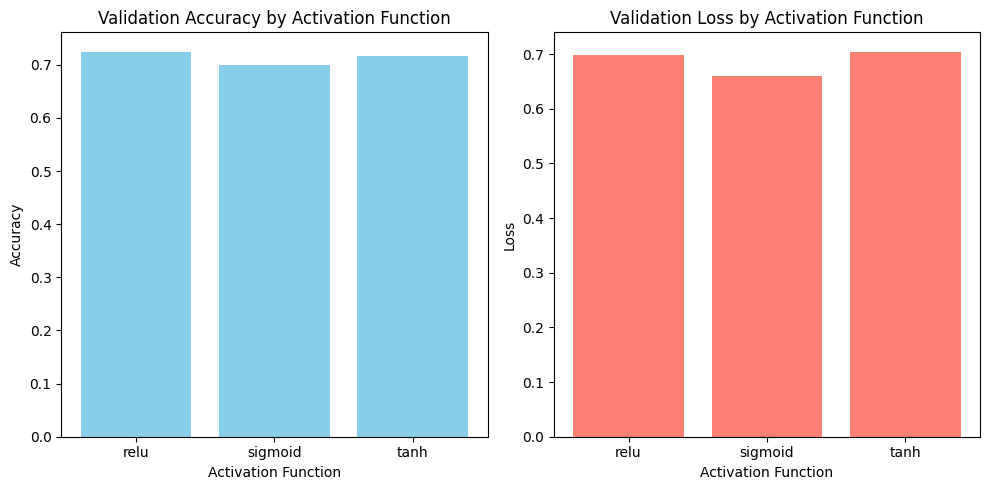

In [14]:
activations = list(results.keys())
val_accuracies = [results[act]['val_accuracy'] for act in activations]
val_losses = [results[act]['val_loss'] for act in activations]

plt.figure(figsize=(10, 5))

# Bar chart: Validation Accuracy
plt.subplot(1, 2, 1)
plt.bar(activations, val_accuracies, color='skyblue')
plt.title('Validation Accuracy by Activation Function')
plt.ylabel('Accuracy')
plt.xlabel('Activation Function')

# Bar chart: Validation Loss
plt.subplot(1, 2, 2)
plt.bar(activations, val_losses, color='salmon')
plt.title('Validation Loss by Activation Function')
plt.ylabel('Loss')
plt.xlabel('Activation Function')

plt.tight_layout()
plt.show()

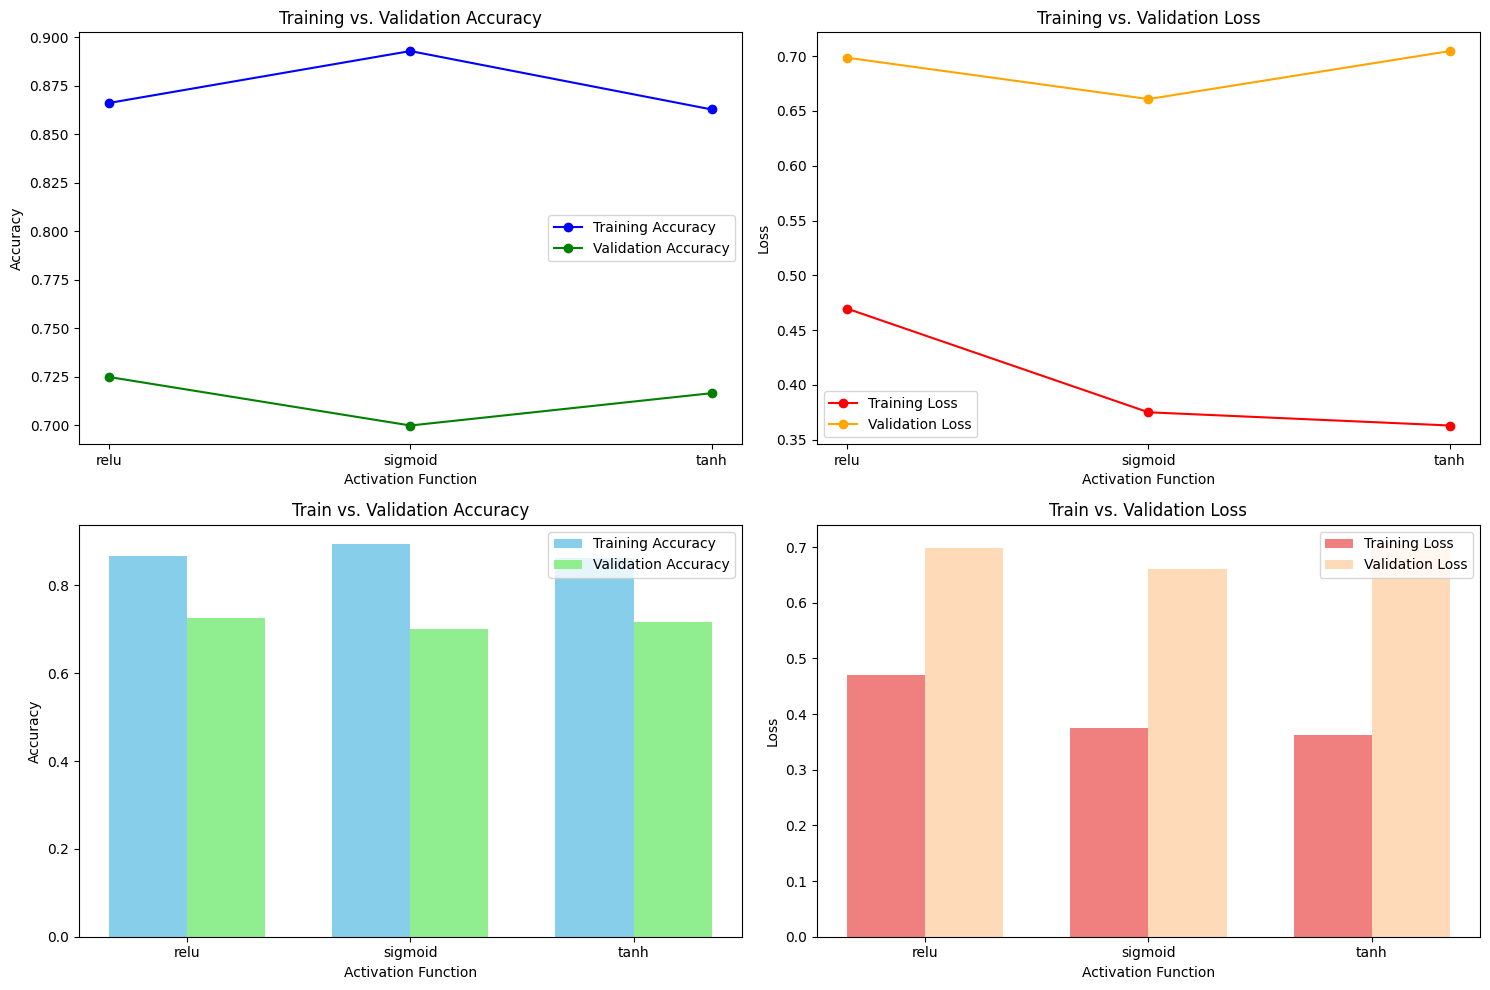

In [16]:
# Extract additional data for visualizations
train_accuracies = [results[act]['train_accuracy'] for act in activations]
train_losses = [results[act]['train_loss'] for act in activations]

# Create a new figure for additional visualizations
plt.figure(figsize=(15, 10))

# Line Plot: Training vs. Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(activations, train_accuracies, marker='o', label='Training Accuracy', color='blue')
plt.plot(activations, val_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.title('Training vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Activation Function')
plt.legend()

# Line Plot: Training vs. Validation Loss
plt.subplot(2, 2, 2)
plt.plot(activations, train_losses, marker='o', label='Training Loss', color='red')
plt.plot(activations, val_losses, marker='o', label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Activation Function')
plt.legend()

# Bar Chart: Train vs. Validation Accuracy
plt.subplot(2, 2, 3)
bar_width = 0.35
x = np.arange(len(activations))
plt.bar(x - bar_width / 2, train_accuracies, bar_width, label='Training Accuracy', color='skyblue')
plt.bar(x + bar_width / 2, val_accuracies, bar_width, label='Validation Accuracy', color='lightgreen')
plt.title('Train vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Activation Function')
plt.xticks(x, activations)
plt.legend()

# Bar Chart: Train vs. Validation Loss
plt.subplot(2, 2, 4)
plt.bar(x - bar_width / 2, train_losses, bar_width, label='Training Loss', color='lightcoral')
plt.bar(x + bar_width / 2, val_losses, bar_width, label='Validation Loss', color='peachpuff')
plt.title('Train vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Activation Function')
plt.xticks(x, activations)
plt.legend()

plt.tight_layout()
plt.show()

#### Compare and print the results

In [17]:
print("\nPerformance Comparison:")
for activation, metrics in results.items():
    print(f"Activation: {activation}")
    print(f"  Train Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"  Validation Accuracy: {metrics['val_accuracy']:.4f}")
    print(f"  Train Loss: {metrics['train_loss']:.4f}")
    print(f"  Validation Loss: {metrics['val_loss']:.4f}\n")


Performance Comparison:
Activation: relu
  Train Accuracy: 0.8662
  Validation Accuracy: 0.7250
  Train Loss: 0.4697
  Validation Loss: 0.6986

Activation: sigmoid
  Train Accuracy: 0.8930
  Validation Accuracy: 0.7000
  Train Loss: 0.3751
  Validation Loss: 0.6609

Activation: tanh
  Train Accuracy: 0.8629
  Validation Accuracy: 0.7167
  Train Loss: 0.3630
  Validation Loss: 0.7047

